In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms

Import necessary preprocessing functions as demonstrated in 'info_feature'.

In [2]:
dim = 28*28 # dim of the original img
q_dim = 2 # dim of the quantized img
k_fs = 10
suffix = '_reg_k10'

# maps a pixel to quantized index
def q_map(x, threshold=0.4):
    if x < threshold:
        return 0
    else:
        return 1
    
# given a data matrix, returns the mask
def q_mask(X):
    mask = np.zeros((X.shape[0], X.shape[1]*q_dim), dtype=np.float)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            mask[i, j*q_dim+q_map(X[i,j])] = 1
    norm_p = np.sum(mask, axis=0) / X.shape[0]
    return mask, norm_p

# X: data matrix
# feature extracting func
# vanilla implementation too slow. use batch.
def ACE_step(X, f, lr, batch_size, mask, norm_p):
    # E[sum f(X_j)|X_i], res is f.dim = data.dim*q_dim
    def expect_cond(X, f, idx):
        f_mask = np.tile(f, (len(idx), 1)) * mask[idx, :]
        sum_per_row = np.sum(f_mask, axis=1)
        sum_per_col = np.sum(f_mask, axis=0)
        res = np.zeros_like(f)
        for j in range(f.shape[0]):
            # if j % 500 == 0: print('expect_cond: {}-th column'.format(j))
            b = (mask[idx, j] == 1)
            if np.sum(b) > 0:
                res[j] = (np.sum(b * sum_per_row) - np.sum(sum_per_col[j])) / np.sum(b)
        return res
    
    # sqrt(E[sum f(X_i)^2])
    def expect_var(X, f):
        # sum_cov = np.sum(np.sum((np.tile(f, (X.shape[0], 1))*mask)**2))
        # e_cov = sum_cov / X.shape[0]
        # res = np.sqrt(e_cov)
        
        res = np.sqrt(np.sum((f**2) * norm_p))
        return res
    
    batch_idx = np.random.choice(X.shape[0], batch_size, False)
    e_cond = expect_cond(X, f, batch_idx)
    new_f = f + lr*e_cond
    cov = expect_var(X, new_f)
    
    new_f = new_f / cov
    return new_f

def init_f(dim=28*28, q_dim=2):
    res_dim = dim * q_dim
    res = np.random.rand(res_dim)
    for j in range(dim):
        res[j*q_dim : (j+1)*q_dim] -= np.sum(res[j*q_dim : (j+1)*q_dim])/2
    return res

def ACE_f(X, mask, norm_p, lr, batch_size, dim=28*28, q_dim=2, epsilon=0.01, max_step=500):
    f_1 = init_f(dim, q_dim)
    for _step in range(max_step):
        f_2 = ACE_step(X, f_1, lr, batch_size, mask, norm_p)
        delta = np.sum((f_1 - f_2)**2)
        f_1 = f_2
        print('Step {}: delta after ACE_step: {}'.format(_step, delta))
        if delta < epsilon:
            break
    return f_1

def norm_dot(f1, f2, norm_p):
    res = np.sum(f1 * f2 * norm_p)
    return res

def ACE_fs(X, k, mask, norm_p, lr=0.8, batch_size=512, dim=28*28, q_dim=2, epsilon=0.01, max_step=500):
    res = []
    for i in range(k):
        print('Building the {}-th feature function...'.format(i))
        f_i = ACE_f(X, mask, norm_p, lr, batch_size, dim, q_dim, epsilon, max_step)
        f_tmp = np.zeros_like(f_i)
        for f_m in res:
            f_tmp = f_tmp + norm_dot(f_i, f_m, norm_p)*f_m
        f_i -= f_tmp
        res.append(f_i)
    return res

Load all the training MNIST as a big matrix

X: n x (28*28)
mask: n x (28*28*2)

In [3]:
dataroot = 'D:\Lab\dataset'

total_train_dataset = datasets.MNIST(dataroot, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ]))
test_dataset = datasets.MNIST(dataroot, train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ]))

total_train_size = len(total_train_dataset)
split_ratio = 0.8
train_size = int(split_ratio * total_train_size)
valid_size = total_train_size - train_size
test_size = len(test_dataset)

train_dataset, valid_dataset = random_split(total_train_dataset,[train_size, valid_size] )
print('n: {}'.format(len(train_dataset)))

n: 48000


In [4]:
img, label = train_dataset[0]
print(train_size)
print(img.shape)

48000
torch.Size([1, 28, 28])


In [5]:
X = np.zeros((train_size, dim))
for idx, (img, _) in enumerate(train_dataset):
    X[idx, :] = img.numpy().transpose(1, 2, 0).flatten()
    if idx%5000 == 0: print(idx)
mask, norm_p = q_mask(X)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000


In [6]:
print(X.shape)
print(mask.shape)
print(mask[0][700:800])
print(norm_p.shape)
print(norm_p[700:800])

(48000, 784)
(48000, 1568)
[1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1.
 0. 1. 0. 1.]
(1568,)
[6.20270833e-01 3.79729167e-01 5.69479167e-01 4.30520833e-01
 5.18479167e-01 4.81520833e-01 5.02458333e-01 4.97541667e-01
 5.46229167e-01 4.53770833e-01 6.40062500e-01 3.59937500e-01
 7.51500000e-01 2.48500000e-01 8.37062500e-01 1.62937500e-01
 9.00020833e-01 9.99791667e-02 9.46000000e-01 5.40000000e-02
 9.80583333e-01 1.94166667e-02 9.98020833e-01 1.97916667e-03
 9.99583333e-01 4.16666667e-04 9.99979167e-01 2.08333333e-05
 1.00000000e+00 0.00000000e+00 9.99958333e-01 4.16666667e-05
 9.99479167e-01 5.20833333e-04 9.97541667e-01 2.45833333e-03
 9.87583333e-01 1.24166667e-02 9.54354167e-01 4.56458333e-02
 8.91291667e-01 1.08708333e-01 7.97854167e-01 2.0

Build the feature extracting func. f

In [7]:
import pickle
feature_path = './models/feats' + suffix

if False:
    fs = ACE_fs(X, k_fs, mask, norm_p, 1, train_size, epsilon=0.0000000001, max_step=10)
    with open(feature_path, 'wb') as fp:
        pickle.dump(fs, fp)
else:
    with open(feature_path, 'rb') as fp:
        fs = pickle.load(fp)
print(len(fs))

10


In [8]:
class InfoTrans(object):
    def __init__(self, map_func, q_dim, fs):
        self.map_func = map_func
        self.fs = fs
        self.k_fs = len(fs)
    
    def __call__(self, img):
        img = img.numpy().transpose(1, 2, 0).flatten()
        dim = len(img)
        
        # returns features
        feats = np.zeros(self.k_fs*len(img))
        for idx, pixel in enumerate(img):
            for k in range(self.k_fs):
                feats[k*dim+idx] = self.fs[k][idx*q_dim+self.map_func(pixel)]
        feats = feats
        
        return feats   

In [9]:
processed_train_file = './models/processed_train' + suffix + '.npz'
processed_valid_file = './models/processed_valid' + suffix + '.npz'
processed_test_file = './models/processed_test' + suffix + '.npz'
train_max_min_file = './models/train_max_min' + suffix + '.npz'

if False:
    processed_train = np.zeros((train_size, k_fs*dim))
    processed_label = np.zeros((train_size, 1))
    for idx, (img, label) in enumerate(train_dataset):
        processed_train[idx, :] = InfoTrans(q_map, q_dim, fs)(img)
        processed_label[idx, 0] = label
        if idx%1000==0: print(idx)
            
    train_min, train_max = np.zeros(k_fs), np.zeros(k_fs)
    for k in range(k_fs):
        train_max[k] = np.max(processed_train[:, k*dim:(k+1)*dim])
        train_min[k] = np.min(processed_train[:, k*dim:(k+1)*dim])
        
    print(train_max)
    print(train_min)
    
    with open(train_max_min_file, 'wb') as fp:
        np.savez(fp, train_max=train_max, train_min=train_min)
    
    for k in range(k_fs):
        processed_train[:, k*dim:(k+1)*dim] = (processed_train[:, k*dim:(k+1)*dim] - train_min[k]) / (train_max[k] - train_min[k]) * 2 - 1

    with open(processed_train_file, 'wb') as fp:
        #torch.save(processed_train, fp)
        np.savez(fp, img=processed_train, label=processed_label)

    processed_valid = np.zeros((valid_size, k_fs*dim))
    processed_label = np.zeros((valid_size, 1))
    for idx, (img, label) in enumerate(valid_dataset):
        processed_valid[idx, :] = InfoTrans(q_map, q_dim, fs)(img)
        processed_label[idx, 0] = label
        if idx%1000==0: print(idx)
        
    for k in range(k_fs):
        processed_valid[:, k*dim:(k+1)*dim] = (processed_valid[:, k*dim:(k+1)*dim] - train_min[k]) / (train_max[k] - train_min[k]) * 2 - 1
        
    with open(processed_valid_file, 'wb') as fp:
        #torch.save(processed_valid, fp)
        np.savez(fp, img=processed_valid, label=processed_label)

    processed_test = np.zeros((test_size, k_fs*dim))
    processed_label = np.zeros((test_size, 1))
    for idx, (img, label) in enumerate(test_dataset):
        processed_test[idx, :] = InfoTrans(q_map, q_dim, fs)(img)
        processed_label[idx, 0] = label
        if idx%1000==0: print(idx)            
        
    for k in range(k_fs):
        processed_test[:, k*dim:(k+1)*dim] = (processed_test[:, k*dim:(k+1)*dim] - train_min[k]) / (train_max[k] - train_min[k]) * 2 - 1

    with open(processed_test_file, 'wb') as fp:
        #torch.save(processed_test, fp)
        np.savez(fp, img=processed_test, label=processed_label)
    
print('Done!')

Done!


In [10]:
class InfoMNIST(torch.utils.data.Dataset):
    def __init__(self, train=True, transform=None, target_transform=None, 
                 processed_train_file = processed_train_file,
                 processed_valid_file = processed_valid_file, 
                 processed_test_file = processed_test_file):
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if self.train=='train':
            filename = processed_train_file
        elif self.train=='valid':
            filename = processed_valid_file
        else:
            filename = processed_test_file
        with open(filename, 'rb') as fp:
            npzfile = np.load(fp)
            self.length = npzfile['label'].shape[0]
            self.img = torch.from_numpy(npzfile['img']).float()
            self.label = torch.from_numpy(npzfile['label'].flatten()).long()

    def __getitem__(self, index):
        img, target = self.img[index], self.label[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return self.length

# Visualization of Features

mean_var_file = './models/mean_var'

if True:
    b_size = 20000

    train_loader_vis = torch.utils.data.DataLoader(
        InfoMNIST('train'),
        batch_size=b_size, shuffle=True)
    '''
    train_mean = torch.zeros((1, k_fs*dim))
    train_var = torch.zeros((1, k_fs*dim))
    for img, label in train_loader_vis:
        train_mean += torch.sum(img, 0, keepdim=True)
    train_mean /= train_size

    for img, label in train_loader_vis:
        train_var += torch.sum((img - train_mean)**2, 0, keepdim=True)
    train_var = torch.sqrt(train_var) / train_size
    
    train_mean = train_mean.numpy()
    train_var = train_var.numpy()
    '''
    train_mean, train_var, train_min, train_max = np.zeros(k_fs), np.zeros(k_fs), np.zeros(k_fs), np.zeros(k_fs)
    for img, label in train_loader_vis:
        for k in range(k_fs):
            train_mean[k] = np.mean(img.numpy()[:, k*dim:(k+1)*dim])        
            train_var[k] = np.var(img.numpy()[:, k*dim:(k+1)*dim])
            train_max[k] = np.max(img.numpy()[:, k*dim:(k+1)*dim])
            train_min[k] = np.min(img.numpy()[:, k*dim:(k+1)*dim])
        break
    
    with open(mean_var_file, 'wb') as fp:
        np.savez(fp, mean=train_mean, var=train_var)
else:
    with open(mean_var_file, 'rb') as fp:
        npzfile = np.load(fp)
        train_mean, train_var = npzfile['mean'], npzfile['var']

print(train_mean)
print(train_var) 
print(train_max)
print(train_min)

class NormalTrans(object):
    def __init__(self, mean, var, _max, _min):
        self.mean = mean
        self.var = var
        self._max = _max
        self._min = _min
    
    def __call__(self, img):
        res = img
        for k in range(k_fs):
            res[k*dim:(k+1)*dim] = (img[k*dim:(k+1)*dim] - self._min[k]) / (self._max[k] - self._min[k]) * 2 - 1#/ self.var        
        return res   

In [11]:
b_size = 1000
train_loader = torch.utils.data.DataLoader(
    InfoMNIST('train'),
    batch_size=b_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(
    InfoMNIST('valid'),
    batch_size=b_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    InfoMNIST('test'),
    batch_size=b_size, shuffle=True)

torch.Size([1000, 7840])
tensor(0.2827)
tensor(-0.3357)
tensor(0.1331)
tensor(-0.2735)
tensor(-0.3107)
tensor(0.1113)
tensor(0.2572)
tensor(0.2755)
tensor(-0.3300)
tensor(-0.2585)
tensor([ 0.2682,  0.2682,  0.2682,  ..., -0.2424, -0.2424, -0.2424])
torch.Size([1000])


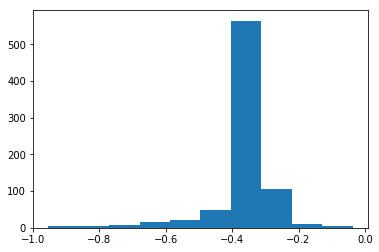

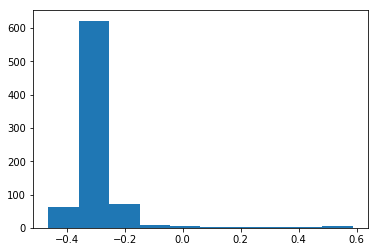

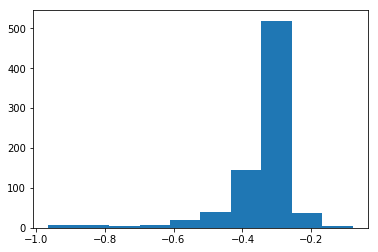

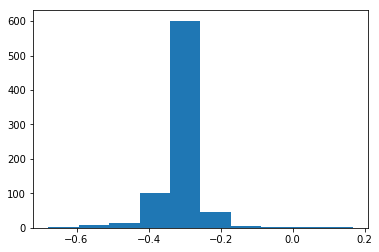

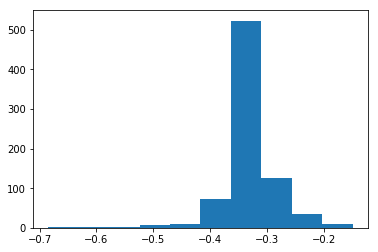

In [12]:
it = iter(test_loader)
test_img, test_label = it.next()
print(test_img.shape)
for i in range(k_fs):
    print(torch.mean(test_img[0][i*28*28:(i+1)*28*28], 0))
print(test_img[0][:])
print(test_label.shape)
for i in range(5):
    test_img, test_label = it.next()
    plt.hist(test_img[0][28*28:2*28*28])
    plt.show()

## visualize the 1st feature

In [13]:
def imshow(npimg):
    npimg = npimg * 0.5 + 0.5
    npimg = npimg.reshape((28,28))
    plt.imshow(npimg, cmap='gray')
    plt.show()

tensor([ 0.2682,  0.2682,  0.2682,  ..., -0.2424, -0.2424, -0.2424])


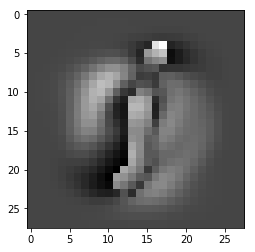

tensor(1)
tensor([ 0.2682,  0.2682,  0.2682,  ..., -0.2424, -0.2424, -0.2424])


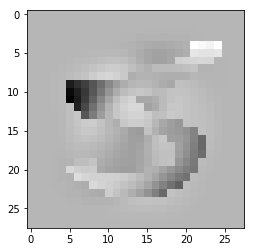

tensor(5)
tensor([ 0.2682,  0.2682,  0.2682,  ..., -0.2424, -0.2424, -0.2424])


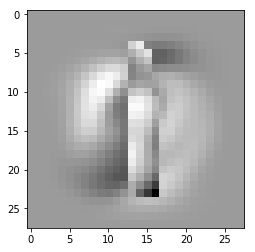

tensor(1)
tensor([ 0.2682,  0.2682,  0.2682,  ..., -0.2424, -0.2424, -0.2424])


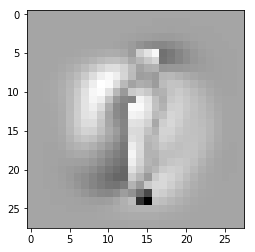

tensor(1)
tensor([ 0.2682,  0.2682,  0.2682,  ..., -0.2424, -0.2424, -0.2424])


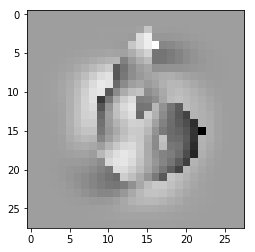

tensor(6)
tensor([ 0.2682,  0.2682,  0.2682,  ..., -0.2424, -0.2424, -0.2424])


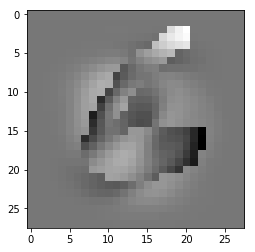

tensor(6)
tensor([ 0.2682,  0.2682,  0.2682,  ..., -0.2424, -0.2424, -0.2424])


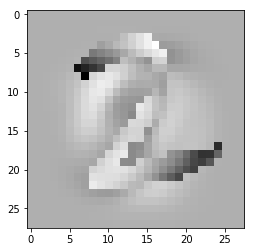

tensor(2)
tensor([ 0.2682,  0.2682,  0.2682,  ..., -0.2424, -0.2424, -0.2424])


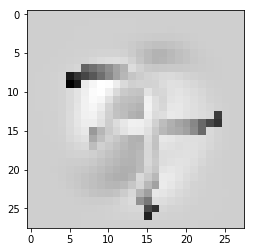

tensor(7)


In [14]:
for k in range(1):
    for j in range(8):
        print(test_img[j])
        imshow(test_img[j].numpy()[k*28*28:(k+1)*28*28])
        print(test_label[j])

(1568,)
[ 3.57142857e-02 -2.77615808e-15  3.57142857e-02 -5.27125912e-15
  3.57142857e-02 -2.43966588e-15  3.57142857e-02 -2.02525155e-16
  3.57142857e-02  4.30449802e-15  3.57142857e-02 -1.96027942e-15
  3.57142857e-02 -4.76893506e-15  3.57142857e-02 -2.92678628e-15
  3.57142857e-02  1.03485986e-15  3.57142857e-02  4.53224760e-15
  3.57142857e-02  2.92812682e-15  3.57142857e-02  2.86906844e-15
  3.57142857e-02  3.57142851e-02  3.57142857e-02  3.57142851e-02
  3.57142857e-02 -3.66540209e-16  3.57142857e-02  4.76892098e-16
  3.57142857e-02 -6.46227468e-15  3.57142857e-02 -2.47196918e-17
  3.57142857e-02  5.16647946e-15  3.57142857e-02 -4.60964543e-15
  3.57142857e-02 -1.99241319e-15  3.57142857e-02  3.87106033e-15
  3.57142857e-02  4.89427966e-15  3.57142857e-02 -6.15630548e-16
  3.57142857e-02 -3.51171229e-15]


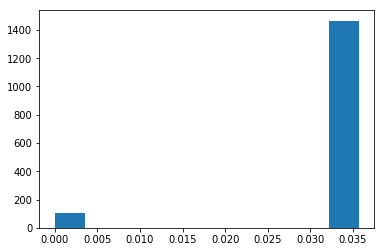

In [15]:
print(fs[0].shape)
print(fs[0][:50])
plt.hist(fs[0])
plt.show()

In [16]:
# Training settings
n_epochs = 500
lr = 0.0001
valid_step = 100
patience = max_patience = 20
best_loss = 100000
best_acc = 0
model_file = './models/model_info' + suffix + '.md'


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28*k_fs, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.dropout(x, training=self.training, p=0.8)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training, p=0.8)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)    

def test_validate(model, device, test_loader, test_valid='Test'):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    print('\n{} set: Average loss: {:.6f}, Accuracy: {}/{} ({:.6f}%)\n'.format(
        test_valid, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, test_acc
    
def train(model, device, train_loader, valid_loader, optimizer, epoch):
    global best_loss, best_acc, patience
    for batch_idx, (data, target) in enumerate(train_loader):
        #print(data[0].numpy()[:28*28])
        #print(target[0])
        model.train()
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        if batch_idx % valid_step == 0:
            print('Start Validating...')
            valid_loss, valid_acc = test_validate(model, device, valid_loader, 'Valid')
            # Very strange. Acc. improve, but loss increase.
            # if valid_loss < best_loss:
            #    best_loss = valid_loss
            if valid_acc > best_acc:
                best_acc = valid_acc
                patience = max_patience
                #print('Bese valid loss: {}'.format(best_loss))
                print('Improved! Reset patience.')
                print('Saving model...')
                torch.save(model, model_file)
            else:
                patience -= 1
                print('Not improved... Patience: {}'.format(patience))
                if patience == 0:
                    print('Out of patience. Stop training.')
                    return

def main():        
    dataroot = 'D:\Lab\dataset'
    
    print(len(train_loader.dataset))
    device = torch.device("cuda")
    
    model = Net().to(device)
    print(model)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, n_epochs + 1):
        train(model, device, train_loader, valid_loader, optimizer, epoch)
        if patience == 0:
            break
                
    print('Start testing...')
    model = torch.load(model_file)
    test_validate(model, device, test_loader)
        
main()

48000
Net(
  (fc1): Linear(in_features=7840, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
Train Epoch: 1 [0/48000 (0%)]	Loss: 2.340846
Start Validating...

Valid set: Average loss: 2.838676, Accuracy: 1137/12000 (9.475000%)

Improved! Reset patience.
Saving model...


C:\Users\Likit\Anaconda3\envs\tensorflow\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train Epoch: 2 [0/48000 (0%)]	Loss: 2.285292
Start Validating...

Valid set: Average loss: 2.697229, Accuracy: 4397/12000 (36.641667%)

Improved! Reset patience.
Saving model...
Train Epoch: 3 [0/48000 (0%)]	Loss: 2.190943
Start Validating...

Valid set: Average loss: 2.581866, Accuracy: 5673/12000 (47.275000%)

Improved! Reset patience.
Saving model...
Train Epoch: 4 [0/48000 (0%)]	Loss: 2.100987
Start Validating...

Valid set: Average loss: 2.591681, Accuracy: 5892/12000 (49.100000%)

Improved! Reset patience.
Saving model...
Train Epoch: 5 [0/48000 (0%)]	Loss: 2.025968
Start Validating...

Valid set: Average loss: 2.556851, Accuracy: 6441/12000 (53.675000%)

Improved! Reset patience.
Saving model...
Train Epoch: 6 [0/48000 (0%)]	Loss: 2.006074
Start Validating...

Valid set: Average loss: 2.504960, Accuracy: 7083/12000 (59.025000%)

Improved! Reset patience.
Saving model...
Train Epoch: 7 [0/48000 (0%)]	Loss: 1.945805
Start Validating...

Valid set: Average loss: 2.515503, Accuracy:

Train Epoch: 49 [0/48000 (0%)]	Loss: 1.424175
Start Validating...

Valid set: Average loss: 2.639440, Accuracy: 9495/12000 (79.125000%)

Not improved... Patience: 19
Train Epoch: 50 [0/48000 (0%)]	Loss: 1.483281
Start Validating...

Valid set: Average loss: 2.760153, Accuracy: 9615/12000 (80.125000%)

Improved! Reset patience.
Saving model...
Train Epoch: 51 [0/48000 (0%)]	Loss: 1.437841
Start Validating...

Valid set: Average loss: 2.723375, Accuracy: 9619/12000 (80.158333%)

Improved! Reset patience.
Saving model...
Train Epoch: 52 [0/48000 (0%)]	Loss: 1.426613
Start Validating...

Valid set: Average loss: 2.675922, Accuracy: 9659/12000 (80.491667%)

Improved! Reset patience.
Saving model...
Train Epoch: 53 [0/48000 (0%)]	Loss: 1.483316
Start Validating...

Valid set: Average loss: 2.698972, Accuracy: 9635/12000 (80.291667%)

Not improved... Patience: 19
Train Epoch: 54 [0/48000 (0%)]	Loss: 1.468695
Start Validating...

Valid set: Average loss: 2.705522, Accuracy: 9665/12000 (80.5416


Valid set: Average loss: 2.546235, Accuracy: 9911/12000 (82.591667%)

Not improved... Patience: 19
Train Epoch: 98 [0/48000 (0%)]	Loss: 1.405270
Start Validating...

Valid set: Average loss: 2.680420, Accuracy: 9929/12000 (82.741667%)

Not improved... Patience: 18
Train Epoch: 99 [0/48000 (0%)]	Loss: 1.402745
Start Validating...

Valid set: Average loss: 2.744315, Accuracy: 10031/12000 (83.591667%)

Improved! Reset patience.
Saving model...
Train Epoch: 100 [0/48000 (0%)]	Loss: 1.389463
Start Validating...

Valid set: Average loss: 2.699837, Accuracy: 9959/12000 (82.991667%)

Not improved... Patience: 19
Train Epoch: 101 [0/48000 (0%)]	Loss: 1.366217
Start Validating...

Valid set: Average loss: 2.781874, Accuracy: 9954/12000 (82.950000%)

Not improved... Patience: 18
Train Epoch: 102 [0/48000 (0%)]	Loss: 1.425409
Start Validating...

Valid set: Average loss: 2.791442, Accuracy: 9979/12000 (83.158333%)

Not improved... Patience: 17
Train Epoch: 103 [0/48000 (0%)]	Loss: 1.384168
Start 

Train Epoch: 146 [0/48000 (0%)]	Loss: 1.407394
Start Validating...

Valid set: Average loss: 2.572809, Accuracy: 10049/12000 (83.741667%)

Not improved... Patience: 19
Train Epoch: 147 [0/48000 (0%)]	Loss: 1.408543
Start Validating...

Valid set: Average loss: 2.462546, Accuracy: 10094/12000 (84.116667%)

Not improved... Patience: 18
Train Epoch: 148 [0/48000 (0%)]	Loss: 1.405697
Start Validating...

Valid set: Average loss: 2.395762, Accuracy: 10100/12000 (84.166667%)

Not improved... Patience: 17
Train Epoch: 149 [0/48000 (0%)]	Loss: 1.425389
Start Validating...

Valid set: Average loss: 2.405803, Accuracy: 10046/12000 (83.716667%)

Not improved... Patience: 16
Train Epoch: 150 [0/48000 (0%)]	Loss: 1.375758
Start Validating...

Valid set: Average loss: 2.351026, Accuracy: 10068/12000 (83.900000%)

Not improved... Patience: 15
Train Epoch: 151 [0/48000 (0%)]	Loss: 1.386130
Start Validating...

Valid set: Average loss: 2.186384, Accuracy: 10058/12000 (83.816667%)

Not improved... Patie


Valid set: Average loss: 2.125816, Accuracy: 10086/12000 (84.050000%)

Not improved... Patience: 10
Train Epoch: 195 [0/48000 (0%)]	Loss: 1.437841
Start Validating...

Valid set: Average loss: 2.080823, Accuracy: 10133/12000 (84.441667%)

Not improved... Patience: 9
Train Epoch: 196 [0/48000 (0%)]	Loss: 1.405501
Start Validating...

Valid set: Average loss: 2.118749, Accuracy: 10100/12000 (84.166667%)

Not improved... Patience: 8
Train Epoch: 197 [0/48000 (0%)]	Loss: 1.398705
Start Validating...

Valid set: Average loss: 2.254988, Accuracy: 10138/12000 (84.483333%)

Not improved... Patience: 7
Train Epoch: 198 [0/48000 (0%)]	Loss: 1.292094
Start Validating...

Valid set: Average loss: 2.228803, Accuracy: 10120/12000 (84.333333%)

Not improved... Patience: 6
Train Epoch: 199 [0/48000 (0%)]	Loss: 1.422705
Start Validating...

Valid set: Average loss: 2.166635, Accuracy: 10051/12000 (83.758333%)

Not improved... Patience: 5
Train Epoch: 200 [0/48000 (0%)]	Loss: 1.355646
Start Validating.